# Data Analytics Project - Models

# Pair 1 - BAJAJ-AUTO Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 1 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair1/Pair1_orders.csv')
orders_df.head()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
0,2018-09-04,3184.149902,2735.550049,448.599854,2.186180,SHORT
1,2018-09-05,3145.399902,2772.300049,373.099854,1.220189,FLAT
2,2018-09-06,3164.850098,2783.100098,381.750000,1.330864,FLAT
3,2018-09-07,3329.350098,2923.550049,405.800049,1.638574,SHORT
4,2018-09-10,3278.300049,2868.600098,409.699951,1.688472,SHORT


In [3]:
orders_df.tail()

,Date,HEROMOTOCO_Close,BAJAJ-AUTO_Close,Spread,zscore,Orders
54,2018-11-27,2958.149902,2599.649902,358.500000,1.033390,FLAT
55,2018-11-28,2999.149902,2603.899902,395.250000,1.503591,SHORT
56,2018-11-29,3016.800049,2724.000000,292.800049,0.192787,FLAT
57,2018-11-30,3055.199951,2745.699951,309.500000,0.406456,FLAT
58,2018-12-03,3039.899902,2736.000000,303.899902,0.334805,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

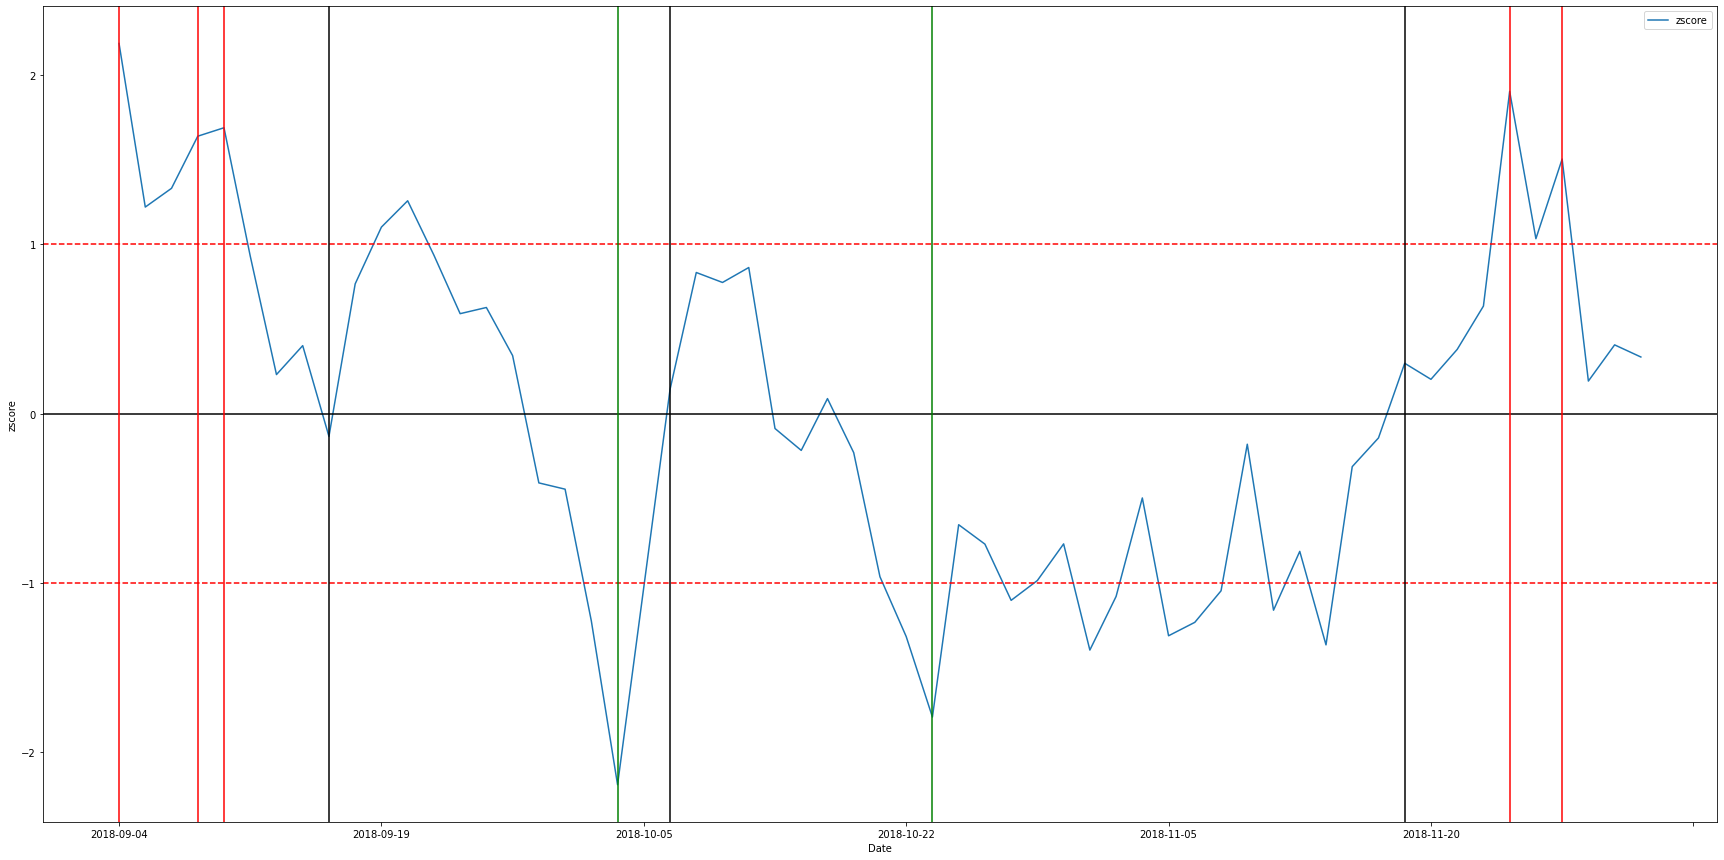

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

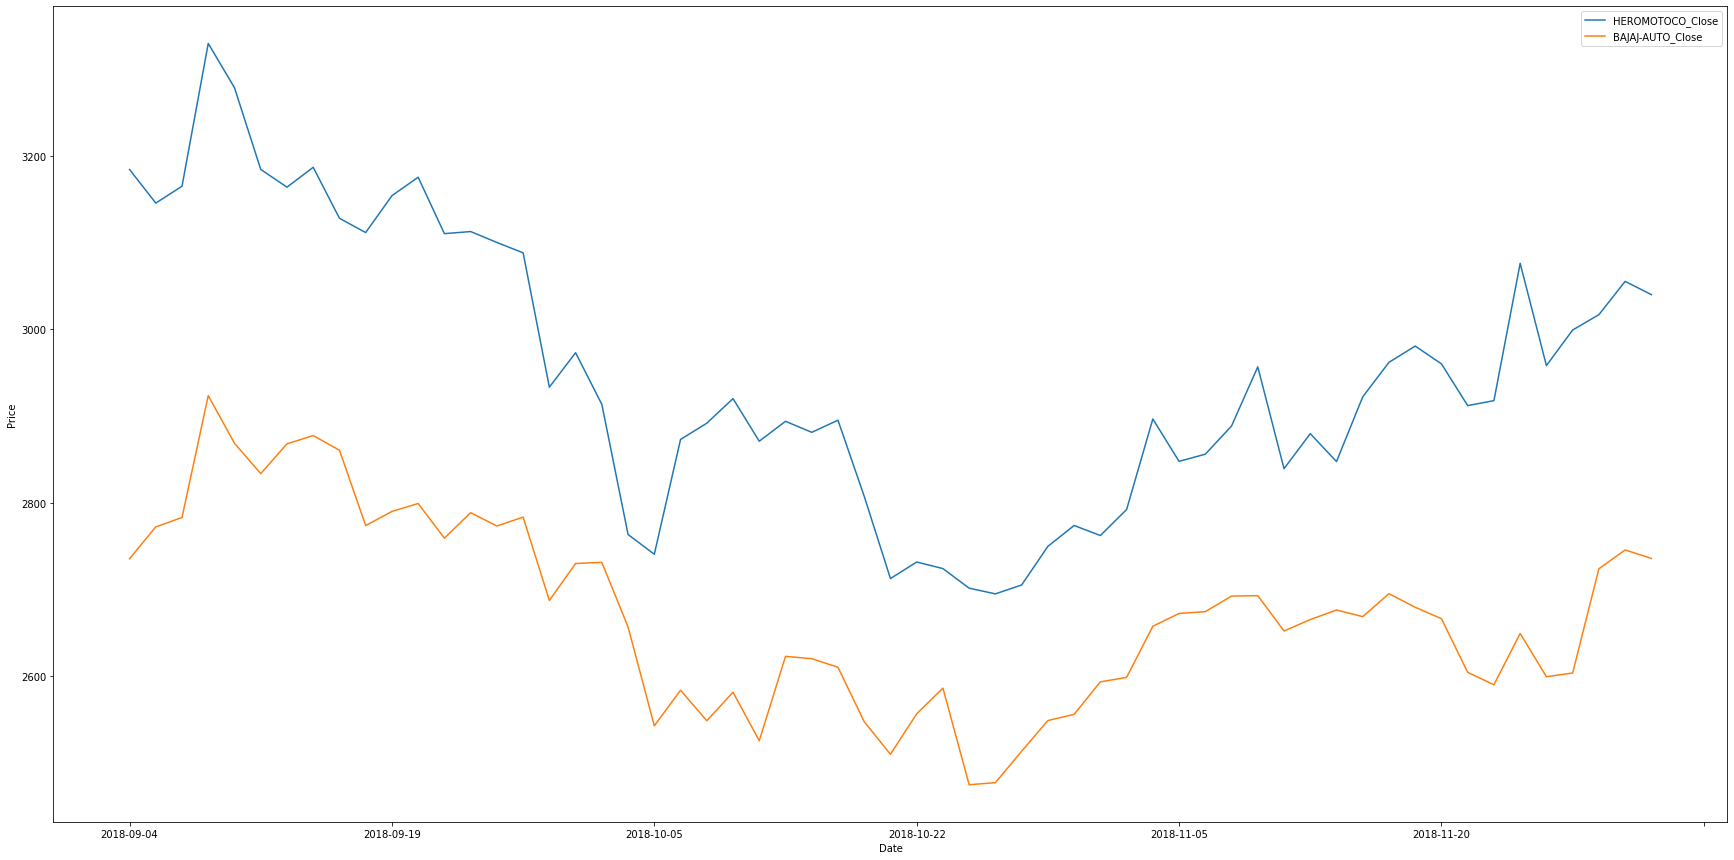

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['HEROMOTOCO_Close', 'BAJAJ-AUTO_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. BAJAJ-AUTO Linear Regression Model

## 3.1. Get the Complete BAJAJ-AUTO dataset

In [6]:
bajaj_df = pd.read_csv("../../Storage/Companies_with_names_exchange/BAJAJ-AUTONSE.csv")
bajaj_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,2654.300049,2552.000000,2642.699951,2598.500000,323342.0,2336.084473,BAJAJ-AUTO,NSE
1,2017-01-03,2632.199951,2561.449951,2594.000000,2619.199951,420196.0,2354.694336,BAJAJ-AUTO,NSE
2,2017-01-04,2698.550049,2615.949951,2625.199951,2684.100098,343922.0,2413.040283,BAJAJ-AUTO,NSE
3,2017-01-05,2730.000000,2685.000000,2694.000000,2723.350098,188686.0,2448.326416,BAJAJ-AUTO,NSE
4,2017-01-06,2739.899902,2696.699951,2721.000000,2707.350098,159484.0,2433.942383,BAJAJ-AUTO,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get BAJAJ-AUTO training data

### 3.2.1 Get complete bajaj dataset

In [7]:
bajaj_df = bajaj_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
bajaj_df.head()

,Date,Close
0,2017-01-02,2598.500000
1,2017-01-03,2619.199951
2,2017-01-04,2684.100098
3,2017-01-05,2723.350098
4,2017-01-06,2707.350098


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
bajaj_df_train = bajaj_df[bajaj_df['Date'] >= '2017-09-03']
bajaj_df_train.head()

,Date,Close
166,2017-09-04,2915.149902
167,2017-09-05,2950.699951
168,2017-09-06,2920.550049
169,2017-09-07,2965.449951
170,2017-09-08,2915.449951


In [9]:
bajaj_df_train = bajaj_df_train[bajaj_df_train['Date'] <= '2018-09-04']
bajaj_df_train.tail()

,Date,Close
412,2018-08-29,2689.100098
413,2018-08-30,2701.649902
414,2018-08-31,2744.850098
415,2018-09-03,2771.899902
416,2018-09-04,2735.550049


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(bajaj_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,2915.149902,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,2950.699951,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,2920.550049,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,2965.449951,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,2915.449951,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,2689.100098,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,2701.649902,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,2744.850098,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,2771.899902,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
bajaj_train_X = bajaj_df_train.copy()

In [12]:
bajaj_train_X = bajaj_train_X.reset_index(drop=True)
bajaj_train_X_plot = bajaj_train_X.copy()
bajaj_train_X = bajaj_train_X.drop(columns=["Elapsed", "Close"])
bajaj_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
bajaj_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
bajaj_train_y = bajaj_df[(bajaj_df['Date'] >= '2017-09-04') & (bajaj_df['Date'] <= '2018-09-04')]['Close']
bajaj_train_y

166    2915.149902
167    2950.699951
168    2920.550049
169    2965.449951
170    2915.449951
          ...     
412    2689.100098
413    2701.649902
414    2744.850098
415    2771.899902
416    2735.550049
Name: Close, Length: 251, dtype: float64

In [15]:
len(bajaj_train_X)

251

In [16]:
len(bajaj_train_y)

251

## 3.3. Get BAJAJ-AUTO Test Data

In [17]:
bajaj_test_df = orders_df.copy()
bajaj_test_df = bajaj_df[(bajaj_df['Date'] >= '2018-09-04') & (bajaj_df['Date'] <= '2018-12-03')].copy()
bajaj_test_df.head()

,Date,Close
416,2018-09-04,2735.550049
417,2018-09-05,2772.300049
418,2018-09-06,2783.100098
419,2018-09-07,2923.550049
420,2018-09-10,2868.600098


In [18]:
bajaj_test_df.tail()

,Date,Close
470,2018-11-27,2599.649902
471,2018-11-28,2603.899902
472,2018-11-29,2724.000000
473,2018-11-30,2745.699951
474,2018-12-03,2736.000000


In [19]:
add_datepart(bajaj_test_df, 'Date')
bajaj_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,2735.550049,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,2772.300049,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,2783.100098,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,2923.550049,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,2868.600098,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
bajaj_test_X = bajaj_test_df.copy()
bajaj_test_X = bajaj_test_X.drop(columns=['Close', "Elapsed"])
bajaj_test_X.reset_index(drop=True, inplace=True)
bajaj_test_X.index += 251
bajaj_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
bajaj_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
bajaj_test_y = bajaj_df[(bajaj_df['Date'] >= '2018-09-04') & (bajaj_df['Date'] <= '2018-12-03')]
bajaj_test_y.reset_index(drop=True, inplace=True)
bajaj_test_y.index += 251
bajaj_test_y = bajaj_test_y['Close']

In [23]:
bajaj_test_y

251    2735.550049
252    2772.300049
253    2783.100098
254    2923.550049
255    2868.600098
256    2833.699951
257    2867.949951
258    2877.500000
259    2860.649902
260    2773.800049
261    2790.100098
262    2799.199951
263    2759.300049
264    2788.699951
265    2773.300049
266    2783.550049
267    2687.449951
268    2730.100098
269    2731.399902
270    2657.000000
271    2543.050049
272    2584.100098
273    2548.850098
274    2581.800049
275    2525.800049
276    2623.050049
277    2620.449951
278    2610.500000
279    2547.800049
280    2510.250000
281    2556.899902
282    2586.500000
283    2475.149902
284    2477.550049
285    2513.750000
286    2549.100098
287    2556.250000
288    2593.699951
289    2598.850098
290    2657.750000
291    2672.550049
292    2674.600098
293    2692.550049
294    2693.050049
295    2652.300049
296    2665.500000
297    2676.500000
298    2668.850098
299    2695.350098
300    2679.649902
301    2666.500000
302    2604.649902
303    2590.

In [24]:
len(bajaj_test_X)

59

In [25]:
len(bajaj_test_y)

59

## 3.4 Create and Train BAJAJ-AUTO Model

In [26]:
model = LinearRegression()
model = model.fit(bajaj_train_X, bajaj_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(bajaj_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,2828.063046
252,2827.527597
253,2826.992147
254,2826.456697
255,2824.743246
256,2824.207796
257,2823.672347
258,2822.601447
259,2820.887996
260,2820.352546


In [28]:
predictions_df['test_data'] = bajaj_test_y
predictions_df

,predictions,test_data
251,2828.063046,2735.550049
252,2827.527597,2772.300049
253,2826.992147,2783.100098
254,2826.456697,2923.550049
255,2824.743246,2868.600098
256,2824.207796,2833.699951
257,2823.672347,2867.949951
258,2822.601447,2877.500000
259,2820.887996,2860.649902
260,2820.352546,2773.800049


In [29]:
predictions = predictions_df['predictions']
predictions

251    2828.063046
252    2827.527597
253    2826.992147
254    2826.456697
255    2824.743246
256    2824.207796
257    2823.672347
258    2822.601447
259    2820.887996
260    2820.352546
261    2819.817096
262    2818.746197
263    2817.032746
264    2816.497296
265    2815.961846
266    2815.426397
267    2814.890947
268    2877.017643
269    2758.420879
270    2757.885429
271    2757.349979
272    2755.636528
273    2755.101078
274    2754.565628
275    2754.030179
276    2753.494729
277    2751.781278
278    2751.245828
279    2750.710378
280    2749.639479
281    2747.926028
282    2747.390578
283    2746.855128
284    2746.319679
285    2745.784229
286    2744.070777
287    2743.535328
288    2767.235091
289    2850.349923
290    2776.867516
291    2775.154065
292    2774.618615
293    2774.083165
294    2773.012266
295    2771.298815
296    2770.763365
297    2770.227915
298    2769.692466
299    2769.157016
300    2767.443564
301    2766.908115
302    2766.372665
303    2765.

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(bajaj_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(bajaj_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(bajaj_test_y, predictions)))
print('R2 Score:', metrics.r2_score(bajaj_test_y, predictions))

Mean Absolute Error: 117.8660153228754
Mean Squared Error: 18859.49259140318
Root Mean Squared Error: 137.3298678052345
R2 Score: -0.6364630068913395


## 3.6. Visualize the predicitons vs test data

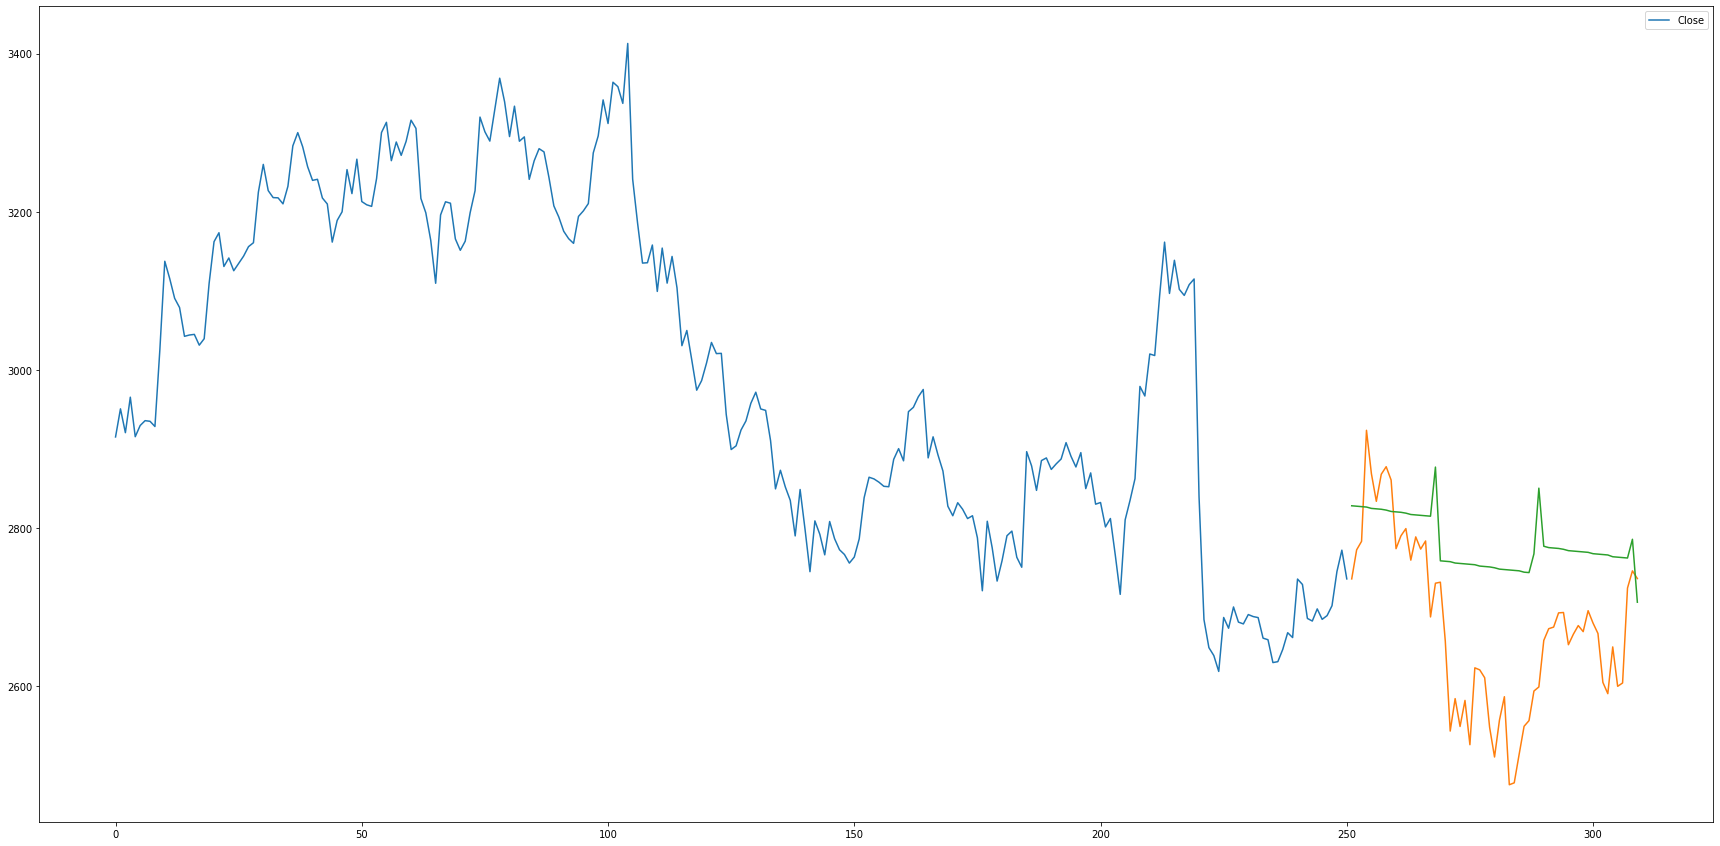

In [31]:
bajaj_model_plt = bajaj_train_X_plot.plot(y=['Close'], figsize=(30,15))
bajaj_model_plt.plot(predictions_df['test_data'])
bajaj_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
bajaj_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['BAJAJ-AUTO_Close']}
bajaj_predictions_df = pd.DataFrame(bajaj_predictions_data)
bajaj_predictions_df.head()

,Date,Actual_Close
0,2018-09-04,2735.550049
1,2018-09-05,2772.300049
2,2018-09-06,2783.100098
3,2018-09-07,2923.550049
4,2018-09-10,2868.600098


In [33]:
predictions_df = predictions_df.reset_index()
bajaj_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
bajaj_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-09-04,2735.550049,2828.063046
1,2018-09-05,2772.300049,2827.527597
2,2018-09-06,2783.100098,2826.992147
3,2018-09-07,2923.550049,2826.456697
4,2018-09-10,2868.600098,2824.743246


In [34]:
bajaj_predictions_df.to_csv('Bajaj_predicitions.csv', index=False)